In [26]:
import numpy as np
from numpy import ma
import pandas as pd
import math
from sklearn import metrics, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Import Data

In [27]:
print(os.getcwd())
relative_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
data = pd.read_csv(relative_path+'/preprocessed_data/non_split_dataset/total_subset.csv')
data = data.drop(['evil','userId'],axis=1)
print(data.shape)

a:\Desktop\FYP Final Files\notebooks\Unsupervised_ML
(1141078, 7)


In [28]:
#X = data.drop(['sus'],axis=1)
X = data
y = data['sus']

# Helpers

In [29]:
def split_data(df: pd.DataFrame) -> pd.DataFrame:
    features = df[["processId", "parentProcessId","mountNamespace", "eventId", "argsNum", "returnValue"]]
    labels = df['sus']
    return features, labels

In [30]:
def print_metrics(y_true, y_predicted):

    accuracy = accuracy_score(y_true, y_predicted)   
    metrics_results = precision_recall_fscore_support(y_true, y_predicted, average="weighted", pos_label=1)
    average_precision = average_precision_score(y_true, y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_true, y_predicted)
    mcc = matthews_corrcoef(y_true, y_predicted)
    
    print(f'Accuracy:\t{accuracy:.3f}')
    print(f'Precision:\t{metrics_results[0]}')
    print(f'Recall:\t\t{metrics_results[1]:.3f}')
    print(f'F1-Score:\t{metrics_results[2]:.3f}')
    print("Average Precision Score:", average_precision)
    print("Balanced Accuracy Score:", balanced_accuracy)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_true , y_predicted)))
    
    #make confusion matrix
    confusion_matrixs = confusion_matrix(y_true, y_predicted)
    

    TP = confusion_matrixs[1][1]
    TN = confusion_matrixs[0][0]
    FP = confusion_matrixs[0][1]
    FN = confusion_matrixs[1][0]


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrixs, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    # Print roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, )
    display.plot()
    plt.show()


    # Assuming test_df_labels is your true labels and mse_test contains continuous score values
    precision, recall, _ = precision_recall_curve(y_true, y_predicted)

    # Calculate the area under the curve
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [31]:
def benign_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def sus_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [32]:
def prepare_labels(y_predicted):
    """
    Helper function to help map out the outputs from models that return -1 for outliers and 1 for inliners.
    """
    y_predicted[y_predicted == 1] = 0
    y_predicted[y_predicted == -1] = 1
    return y_predicted

# Split data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)

In [34]:
X_train = X_train[X_train['sus']==0]
X_train = X_train.drop(columns='sus')
X_test = X_test.drop(columns='sus')

In [35]:
X_train.head()

,processId,parentProcessId,mountNamespace,eventId,argsNum,returnValue
335256,1,1,0,1005,4,0
1043942,1,1,0,1005,4,0
1028670,1,1,1,5,2,0
674605,1,1,0,3,1,0
714299,1,1,0,1005,4,0


# Model training

## Isolation forest

In [36]:
iforest = IsolationForest(random_state=0,contamination=0.05)
iforest.fit(X_train)

IsolationForest(contamination=0.05, random_state=0)

In [37]:
ypred_iforest = iforest.predict(X_test)
ypred_iforest = prepare_labels(ypred_iforest)
print(classification_report(y_test, ypred_iforest,digits=3))

              precision    recall  f1-score   support

           0      0.973     0.951     0.962    193389
           1      0.759     0.851     0.803     34827

    accuracy                          0.936    228216
   macro avg      0.866     0.901     0.882    228216
weighted avg      0.940     0.936     0.938    228216



Accuracy:	0.936
Precision:	0.9400543700289579
Recall:		0.936
F1-Score:	0.938
Average Precision Score: 0.6689660497576833
Balanced Accuracy Score: 0.9014051359763482
Matthews Correlation Coefficient (MCC): 0.7664195091461093
AUC : 0.90141


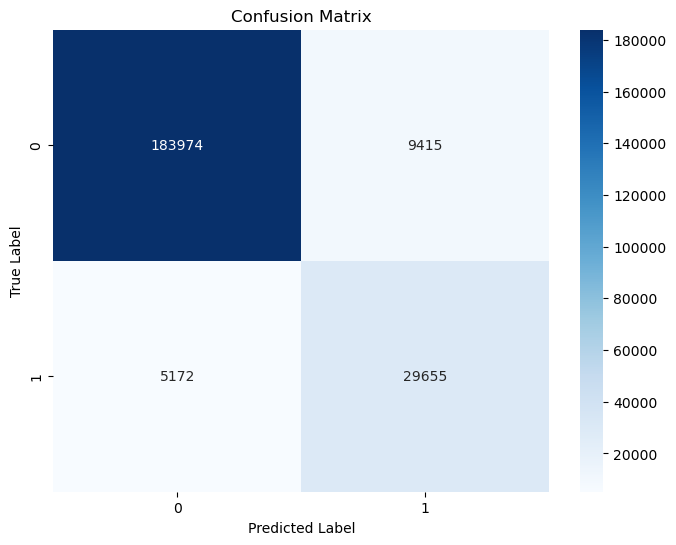

True Positives (TP): 29655
True Negatives (TN): 183974
False Positives (FP): 9415
False Negatives (FN): 5172


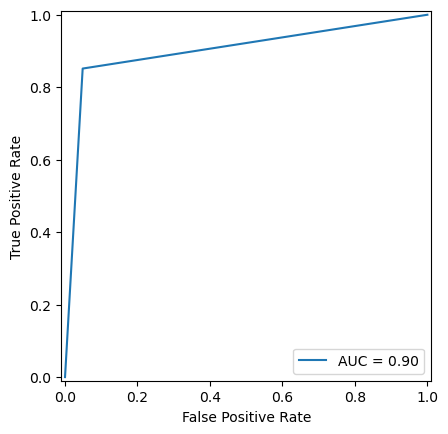

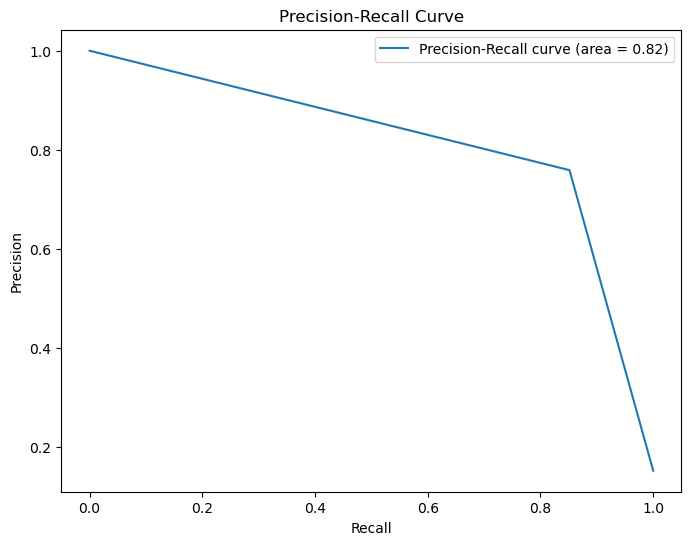

In [38]:
print_metrics(y_test,ypred_iforest)

## Local Outlier Factor

In [39]:
lof = LocalOutlierFactor(contamination=0.05, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.05, novelty=True)

In [40]:
predicted_scores = lof.decision_function(X_test)
predicted_labels = lof.predict(X_test)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      1.00      0.92    193389
           1       0.63      0.00      0.01     34827

    accuracy                           0.85    228216
   macro avg       0.74      0.50      0.46    228216
weighted avg       0.81      0.85      0.78    228216

Accuracy:	0.848
Precision:	0.8145342413347754
Recall:		0.848
F1-Score:	0.779
Average Precision Score: 0.15453602910724556
Balanced Accuracy Score: 0.501809698113657
Matthews Correlation Coefficient (MCC): 0.041564851463842575
AUC : 0.50181


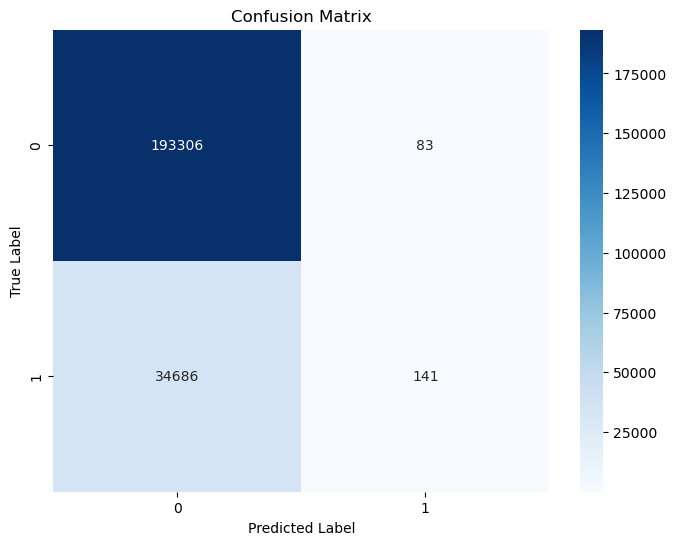

True Positives (TP): 141
True Negatives (TN): 193306
False Positives (FP): 83
False Negatives (FN): 34686


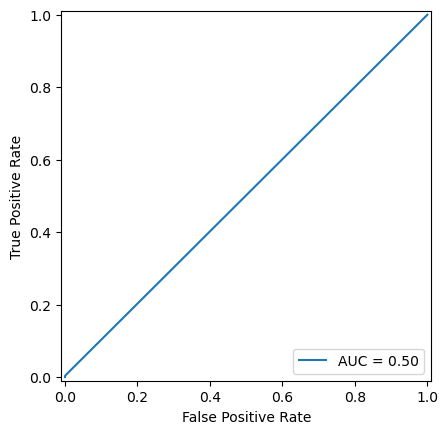

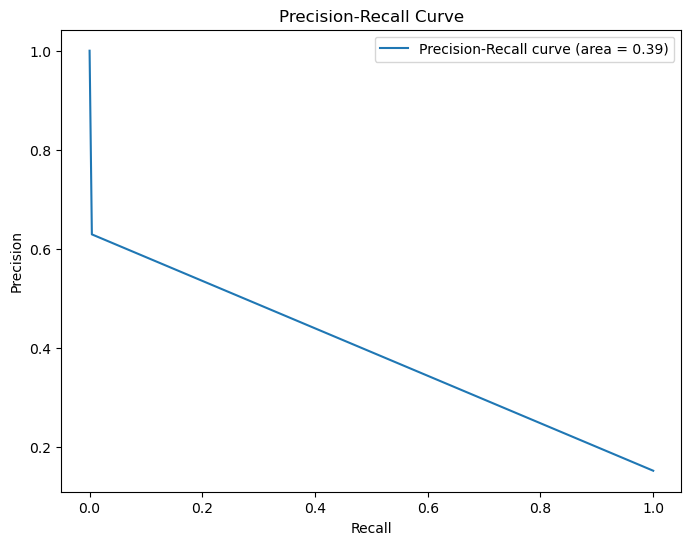

In [41]:
print(classification_report(y_test, predicted_labels))
print_metrics(y_test,predicted_labels)

## SVM

In [42]:
model = linear_model.SGDOneClassSVM(random_state=0).fit(X_train)

              precision    recall  f1-score   support

           0       0.80      0.71      0.75    193389
           1       0.02      0.04      0.03     34827

    accuracy                           0.61    228216
   macro avg       0.41      0.37      0.39    228216
weighted avg       0.68      0.61      0.64    228216

Accuracy:	0.609
Precision:	0.6849833555113135
Recall:		0.609
F1-Score:	0.644
Average Precision Score: 0.14767852060261066
Balanced Accuracy Score: 0.3747035121645893
Matthews Correlation Coefficient (MCC): -0.20799376300519612
AUC : 0.37470


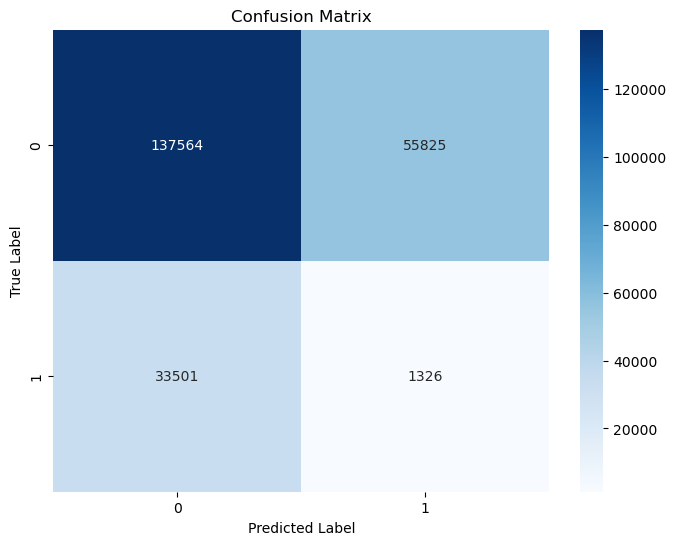

True Positives (TP): 1326
True Negatives (TN): 137564
False Positives (FP): 55825
False Negatives (FN): 33501


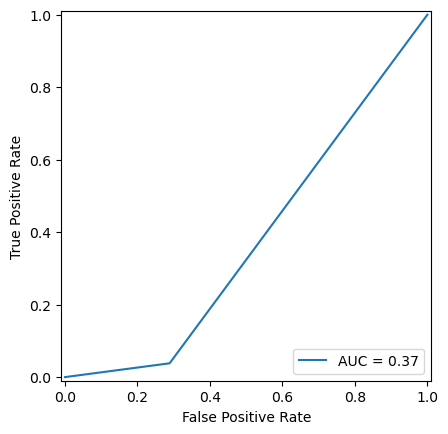

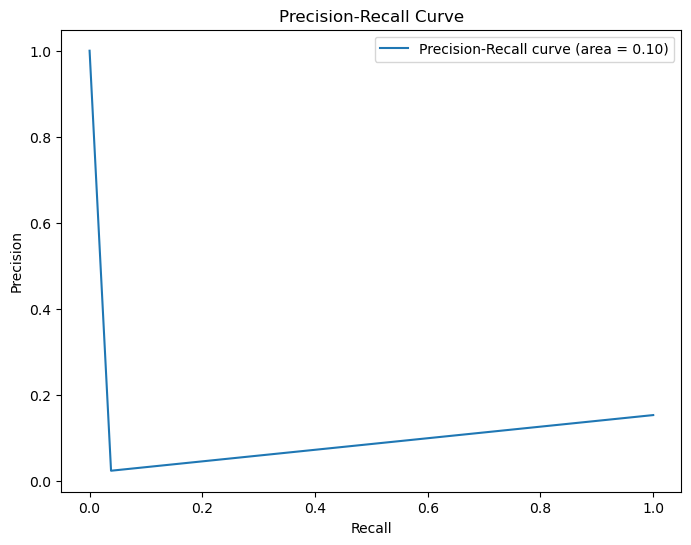

In [43]:
y_pred_svm = model.predict(X_test)
y_pred_svm = prepare_labels(y_pred_svm)
print(classification_report(y_test,y_pred_svm))
print_metrics(y_test,y_pred_svm)

## Autoenconder

In [44]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

input_dim = X_train.shape[1] # Number of features

# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)

# Bottleneck
bottleneck = Dense(32, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation="relu")(bottleneck)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [45]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_weights2.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test, X_test),
    shuffle=True,
    callbacks=[checkpoint]
)
autoencoder.load_weights("best_weights2.keras")

Epoch 1/20
3024/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 727.8165
Epoch 1: val_loss improved from inf to 0.15266, saving model to best_weights2.keras
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 727.4103 - val_loss: 0.1527
Epoch 2/20
3022/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0800
Epoch 2: val_loss improved from 0.15266 to 0.01742, saving model to best_weights2.keras
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0802 - val_loss: 0.0174
Epoch 3/20
3009/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3006
Epoch 3: val_loss did not improve from 0.01742
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3009 - val_loss: 0.0280
Epoch 4/20
3003/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5021
Epoch 4: val_loss improved from 0.01742 to 0.01211, saving model to best_weights2.keras
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.5021 - val_loss: 0.0121
Epoch 5/20
3003/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2199
Epoch 5: val_loss did not improve fr

In [46]:
# Predict on the test set
X_test_pred = autoencoder.predict(X_test)

X_train_pred = autoencoder.predict(X_train)

7132/7132 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
24193/24193 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


In [47]:
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

In [48]:

threshold = np.quantile(mse_train, 0.99)

# Predict anomalies on the test set
y_pred_test = (mse_test > threshold)
y_pred_test = y_pred_test.astype(int)

In [49]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(y_test, y_pred_test))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, mse_test) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.85      0.99      0.91    193389
           1       0.00      0.00      0.00     34827

    accuracy                           0.84    228216
   macro avg       0.42      0.50      0.46    228216
weighted avg       0.72      0.84      0.78    228216

AUC-ROC: 0.50


Accuracy:	0.843
Precision:	0.7179888102846963
Recall:		0.843
F1-Score:	0.775
Average Precision Score: 0.1525925422913802
Balanced Accuracy Score: 0.4974938040446647
Matthews Correlation Coefficient (MCC): -0.027440424406849465
AUC : 0.49749


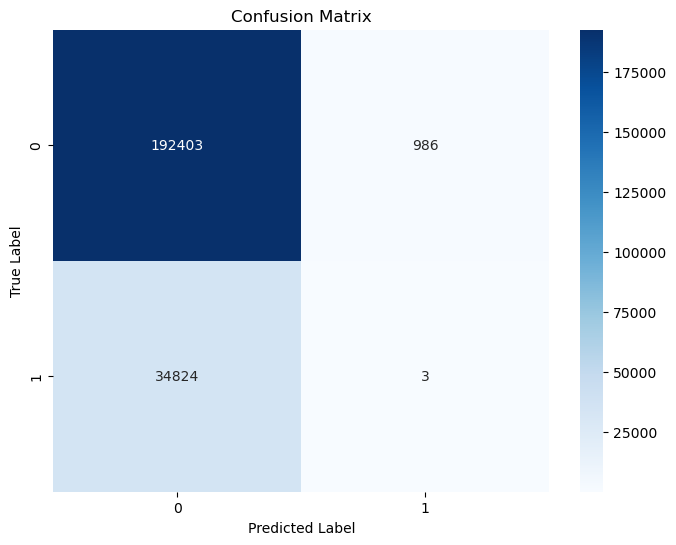

True Positives (TP): 3
True Negatives (TN): 192403
False Positives (FP): 986
False Negatives (FN): 34824


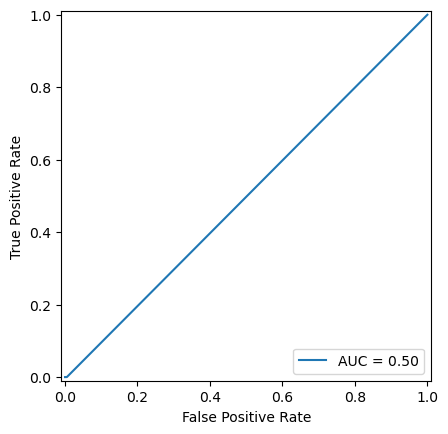

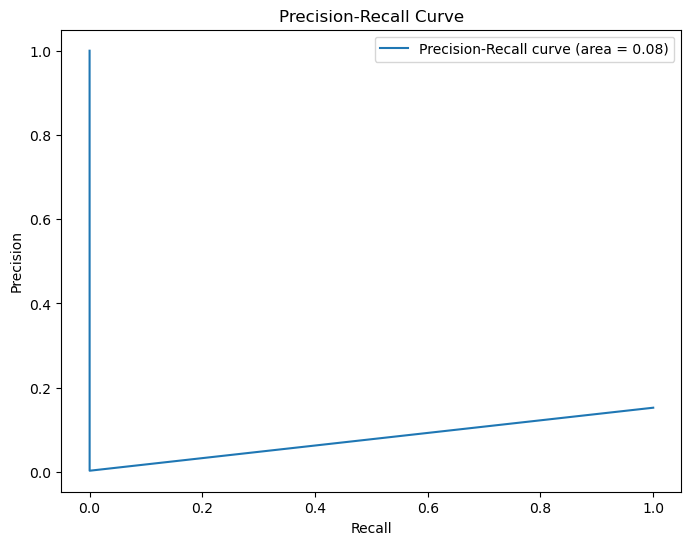

In [50]:
print_metrics(y_test,y_pred_test)